# Dead reckoning for the canonical model
The state of the canonical (unicycle) model is
$$ \zeta = \begin{bmatrix} \theta\\x\\y \end{bmatrix}, $$
and its kinematics is given by
$$ \dot{\zeta} = \begin{bmatrix} \dot{\theta} \\ \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} \omega \\ v\cos\theta \\ v\sin\theta \end{bmatrix}, $$
where $v$ is the linear velocity and $\omega$ is the angular velocity, both of which are considered input signals to the model.

If we have an estimate of the state at some point in time $t_k$, $\hat{\zeta}(t_k) = \hat{\zeta}_k$, we can estimate the state at some (short) time later by integrating the kinematics equation, given knowledge of the input signals. It is common to use Euler's approximation to the derivative 
$$ \dot{\zeta}_k \approx \frac{\zeta_{k+1} - \zeta_k}{\Delta t}, $$
which gives
$$ \frac{\hat{\zeta}_{k+1} - \hat{\zeta}_k}{\Delta t} =  \begin{bmatrix} \omega_k \\ v_k\cos\theta_k \\ v_k\sin\theta_k \end{bmatrix}, $$
leading to 
$$ \hat{\zeta}_{k+1} = \hat{\zeta}_k + \Delta t \begin{bmatrix} \omega_k \\ v_k\cos\theta_k \\ v_k\sin\theta_k \end{bmatrix}. $$

## Example: circular motion
The robot is moving along a circular path with constant linear velocity $v$=1 m/s, and constant angular velocity $\omega$=1 rad/s. Clearly, the radius of the circle is $r$=1 m. At time $t=0$ the robot starts at the origin with linear velocity in the direction of the x-axis. The true state is thus given by
$$\zeta(t) = \begin{bmatrix} \theta(t)\\x(t)\\y(t) \end{bmatrix} = \begin{bmatrix} t \\ \sin(t) \\ 1 - \cos(t) \end{bmatrix}. $$ 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

<IPython.core.display.Javascript object>


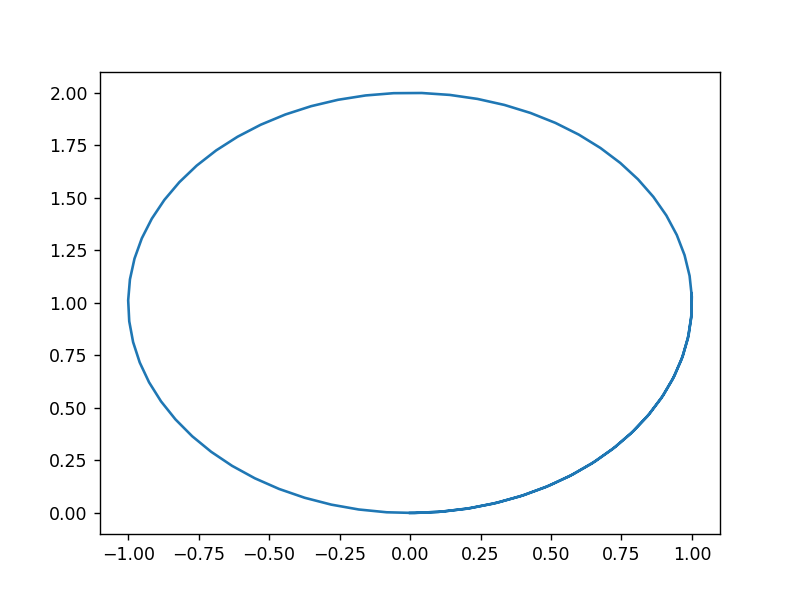

In [3]:
# The true state sequence
dt = 0.1 # Time step
tv = np.arange(80)*dt
zeta_true = np.asarray([(t_, np.sin(t_), 1-np.cos(t_)) for t_ in tv])

# Plotting the path
plt.figure()
plt.plot(zeta_true[:,1], zeta_true[:,2])

## Implement dead reckoning
Implement dead reckoning and compare the resulting path with the true path.

In [4]:
def dead_reckoning(zeta_k, w_k, v_k, dt):
    """
    Returns an estimate of the state of the canonical model by
    integrating the kinematics equation over dt using Euler's method
    
    Argments
    --------
    zeta_k : ndarray (3,)
             The state at time t_k
    w_k    : float
             Angular velocity at time t_k
    v_k    : float
             Linear velocity at time t_k
    
    Returns
    -------
    zeta_kk : ndarray (3,)
              The state at time t_k + dt
    """
    #-----------------------------------------
    # YOUR CODE HERE
    #-----------------------------------------    

    th_k = zeta_k[0]
    return zeta_k + dt*np.array([w_k, v_k*np.cos(th_k), v_k*np.sin(th_k)])
    
zeta0 = np.array([0.0, 0.0, 0.0]) # The initial state
zeta_hat = [] # The estimated states
tt = [] # The time vector
t = 0
zeta_k = zeta0
def v(t): # The linear velocity input signal
    return 1.0
def w(t): # The angular velocity input signal
    return 1.0
while (t < 2*np.pi): # Do one complete revolution
    zeta_hat.append(zeta_k.copy())
    tt.append(t)
    w_k = w(t) # The angular velocity
    v_k = v(t) # The linear velocity 
    zeta_k = dead_reckoning(zeta_k, w_k, v_k, dt)
    t += dt

<IPython.core.display.Javascript object>


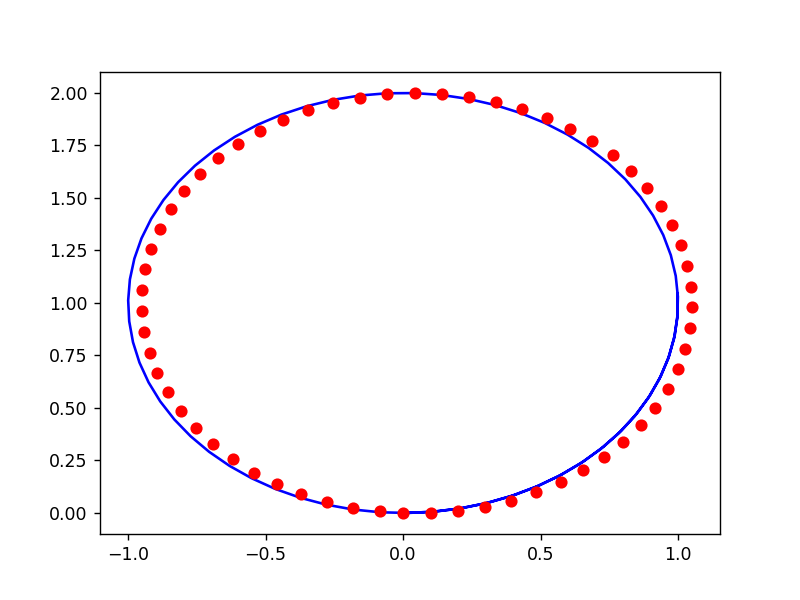

In [5]:
# Plot the results
zeta_hat = np.array(zeta_hat)
plt.figure()
plt.plot(np.sin(tv), 1-np.cos(tv), 'b', zeta_hat[:,1], zeta_hat[:,2], 'ro')
plt.show()

<IPython.core.display.Javascript object>


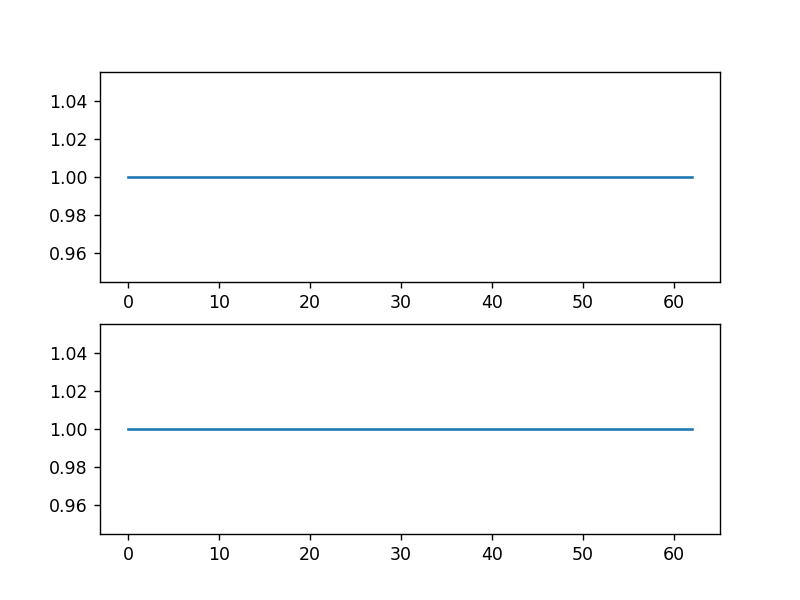

In [7]:
plt.figure()
plt.plot(tv, tv, 'b', tt, zeta_hat[:,0], 'ro')

## Difference between two poses
Convert the state of the canonical model into a pose object, similar to the one used in ROS. See [geometry_msgs/Pose](http://docs.ros.org/en/noetic/api/geometry_msgs/html/msg/Pose.html), with position as a 3D-vector and orientation as a quaternion.

Implement a method that calculates the difference between two poses as an absolute distance and an absolute angle.

The code below makes use of the [transforms3d library](https://matthew-brett.github.io/transforms3d/reference/index.html) by Mathew Brett. 

In [8]:
! pip install transforms3d

You should consider upgrading via the '/home/kjartan/.pyenv/versions/3.8.11/envs/tug/bin/python3.8 -m pip install --upgrade pip' command.


In [26]:
import transforms3d.quaternions as quat
class Pose:
    def __init__(self, position=[0,0,0], orientation=[1,0,0,0]):
        """ Constructor
        Arguments
        ---------
        position : array-like (3,)
                   The position (x, y, z)
        orientation : array-like(4,)
                      The orientation expressed as a quaternion (w, x, y, z)
        """
        self.position = np.asarray(position, dtype='float64')
        self.orientation = np.asarray(orientation, dtype='float64')
        # Make sure orientation is a unit quaternion
        self.orientation /= np.linalg.norm(self.orientation)
        
    def from_robot_state(th, x, y):
        """
        Returns a Pose object corresponding to the pose of a wheeled robot described
        by the canonical nonholonomic model 
        """
        
        #-----------------------------------------
        # YOUR CODE HERE
        #-----------------------------------------    


        return Pose(position=[x,y,0], orientation=[np.cos(th/2),0,0,np.sin(th/2)])
    def diff(self, other):
        """
        Returns the difference between this pose and another pose as an absolute distance
        and an absolute angle
        """

        #-----------------------------------------
        # YOUR CODE HERE
        #-----------------------------------------    
        
        #return (1, 1)
        dist = np.linalg.norm(self.position - other.position)
        qqinv = quat.qmult(self.orientation, quat.qinverse(other.orientation))
        angle = 2*np.arccos(qqinv[0])
        return (dist, angle)
        
    def __repr__(self):
        return """Pose:
          position = [%f, %f, %f]
          orientation = [%f, %f, %f, %f]""" %(*self.position, *self.orientation)
p = Pose(orientation=[0,0,0,0.5])
p.orientation

array([0., 0., 0., 1.])

In [27]:
# Tests
th = np.pi/4
q = quat.axangle2quat([0,0, 1], th, is_normalized=True)
p = Pose.from_robot_state(th, 0, 0)
assert np.allclose(q, p.orientation), "Orientation not as expected"

In [28]:
p_true = [Pose.from_robot_state(th_, x_, y_) for th_, x_, y_ in zeta_true]
p_hat = [Pose.from_robot_state(th_, x_, y_) for th_, x_, y_ in zeta_hat]
estimation_error = np.asarray([p_.diff(phat_) for p_, phat_ in zip(p_true, p_hat)])

<IPython.core.display.Javascript object>


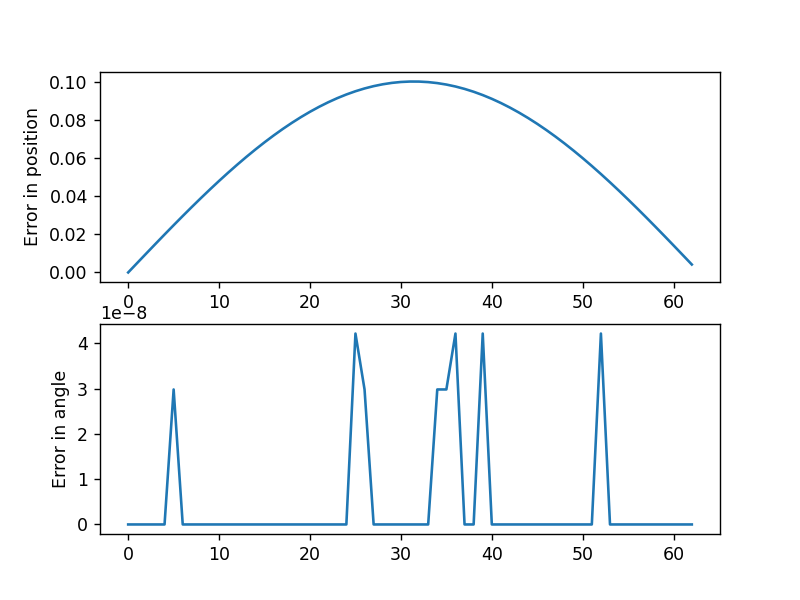

Text(0, 0.5, 'Error in angle')

In [29]:
plt.figure()
plt.subplot(211)
plt.plot(estimation_error[:,0])
plt.ylabel('Error in position')
plt.subplot(212)
plt.plot(estimation_error[:,1])
plt.ylabel('Error in angle')

